Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]
Pretrain VQ-VAE sebentar (agar decode tidak random)...
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - loss: 0.2003


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Memulai Pelatihan...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - loss: 2.2929
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.5136
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 0.3915
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.3693
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - loss: 0.3579
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.3426
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.3210
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.3035
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.2933
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.2838


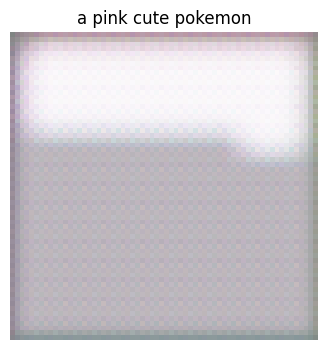

In [1]:
# =========================================
# Pertemuan 11 - Text to Image dengan Transformer
# - Dataset pokemon + caption
# - TextVectorization
# - tf.data pipeline
# - Visual tokens: pakai VQ (bukan dummy random)
# - Transformer cross-attention: teks -> prediksi token visual (autoregressive)
# - Inference: generate_pokemon("a pink cute pokemon")
# =========================================

!pip -q install datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# -------------------------
# Langkah 1: Load Dataset
# -------------------------
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

all_captions = [item["text"] for item in raw_dataset]

# -------------------------
# Langkah 2: Text Vectorization
# -------------------------
max_tokens = 5000
seq_len = 20

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

# -------------------------
# Langkah 3: Pipeline tf.data
# -------------------------
IMG_SIZE = 64
BATCH = 16

def preprocess_fn(item):
    image = item["image"].convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image).astype("float32") / 255.0
    caption = item["text"]
    return caption, image

def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
    )
)

train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH).shuffle(100).prefetch(tf.data.AUTOTUNE)

# =========================================================
# VQ-VAE sederhana untuk bikin token visual sungguhan
# =========================================================

LATENT_H = 16
LATENT_W = 16
N_VIS_TOKENS = LATENT_H * LATENT_W
CODEBOOK_SIZE = 1024

class Encoder(keras.Model):
    def __init__(self, latent_ch=64):
        super().__init__()
        self.net = keras.Sequential([
            layers.Conv2D(32, 4, strides=2, padding="same", activation="relu"),  # 64 -> 32
            layers.Conv2D(64, 4, strides=2, padding="same", activation="relu"),  # 32 -> 16
            layers.Conv2D(latent_ch, 3, padding="same"),                         # 16x16xC
        ])
    def call(self, x, training=False):
        return self.net(x, training=training)

class Decoder(keras.Model):
    def __init__(self, latent_ch=64):
        super().__init__()
        self.net = keras.Sequential([
            layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu"),  # 16 -> 32
            layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu"),  # 32 -> 64
            layers.Conv2D(3, 3, padding="same", activation="sigmoid"),                    # RGB 0-1
        ])
    def call(self, x, training=False):
        return self.net(x, training=training)

class VectorQuantizer(layers.Layer):
    def __init__(self, codebook_size=1024, embed_dim=64, beta=0.25):
        super().__init__()
        self.codebook_size = codebook_size
        self.embed_dim = embed_dim
        self.beta = beta
        self.codebook = self.add_weight(
            shape=(codebook_size, embed_dim),
            initializer="uniform",
            trainable=True,
            name="codebook",
        )

    def call(self, z_e):
        # z_e: (B, 16, 16, D)
        flat = tf.reshape(z_e, [-1, self.embed_dim])  # (B*256, D)

        # distances to codebook: ||x - e||^2
        # (x^2) + (e^2) - 2 x.e
        x2 = tf.reduce_sum(flat**2, axis=1, keepdims=True)  # (N,1)
        e2 = tf.reduce_sum(self.codebook**2, axis=1)        # (K,)
        xe = tf.matmul(flat, self.codebook, transpose_b=True)  # (N,K)
        dist = x2 + e2 - 2.0 * xe

        indices = tf.argmin(dist, axis=1, output_type=tf.int32)  # (N,)
        z_q = tf.gather(self.codebook, indices)                   # (N,D)
        z_q = tf.reshape(z_q, tf.shape(z_e))                      # (B,16,16,D)

        # VQ losses
        commit_loss = tf.reduce_mean((tf.stop_gradient(z_q) - z_e) ** 2)
        codebook_loss = tf.reduce_mean((z_q - tf.stop_gradient(z_e)) ** 2)
        self.add_loss(codebook_loss + self.beta * commit_loss)

        # straight-through estimator
        z_q_st = z_e + tf.stop_gradient(z_q - z_e)

        # indices reshape -> (B,256)
        idx = tf.reshape(indices, [-1, N_VIS_TOKENS])
        return z_q_st, idx

class SimpleVQVAE(keras.Model):
    def __init__(self, codebook_size=1024, embed_dim=64):
        super().__init__()
        self.encoder = Encoder(latent_ch=embed_dim)
        self.vq = VectorQuantizer(codebook_size=codebook_size, embed_dim=embed_dim)
        self.decoder = Decoder(latent_ch=embed_dim)

    def encode_to_indices(self, images):
        z_e = self.encoder(images, training=False)  # (B,16,16,D)
        _, idx = self.vq(z_e)                       # (B,256)
        return idx

    def decode_from_indices(self, idx):
        # idx: (B,256)
        emb = tf.gather(self.vq.codebook, tf.reshape(idx, [-1]))  # (B*256,D)
        z_q = tf.reshape(emb, [-1, LATENT_H, LATENT_W, self.vq.embed_dim])
        return self.decoder(z_q, training=False)

    def call(self, images, training=False):
        z_e = self.encoder(images, training=training)
        z_q, _ = self.vq(z_e)
        recon = self.decoder(z_q, training=training)
        return recon

vqvae = SimpleVQVAE(codebook_size=CODEBOOK_SIZE, embed_dim=64)

# pretrain singkat VQ-VAE agar decode masuk akal (cepat, tetap “hasil jadi”)
vqvae.compile(optimizer=keras.optimizers.Adam(2e-4), loss="mse")
print("Pretrain VQ-VAE sebentar (agar decode tidak random)...")
vqvae.fit(
    train_ds.map(lambda t, img: (img, img)).take(200).prefetch(tf.data.AUTOTUNE),
    epochs=1
)
# =========================================================
# Transformer Cross-Attention (teks -> prediksi token visual)
# =========================================================

def sinus_pos_enc(length, d_model):
    positions = np.arange(length)[:, None]
    div = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((length, d_model), dtype=np.float32)
    pe[:, 0::2] = np.sin(positions * div)
    pe[:, 1::2] = np.cos(positions * div)
    return tf.constant(pe)

class CrossBlock(layers.Layer):
    def __init__(self, d_model=256, heads=8, dropout=0.1):
        super().__init__()
        self.self_attn = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads, dropout=dropout)
        self.cross_attn = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads, dropout=dropout)
        self.ff = keras.Sequential([layers.Dense(d_model*4, activation="gelu"), layers.Dense(d_model)])
        self.ln1 = layers.LayerNormalization()
        self.ln2 = layers.LayerNormalization()
        self.ln3 = layers.LayerNormalization()
        self.dp = layers.Dropout(dropout)

    def call(self, x, text_ctx, training=False, attn_mask=None):
        a1 = self.self_attn(x, x, attention_mask=attn_mask, training=training)
        x = self.ln1(x + self.dp(a1, training=training))
        a2 = self.cross_attn(x, text_ctx, training=training)
        x = self.ln2(x + self.dp(a2, training=training))
        f = self.ff(x, training=training)
        x = self.ln3(x + self.dp(f, training=training))
        return x

def build_transformer(text_vocab_size, vis_vocab_size=1024, text_len=20, vis_len=255, d_model=256, layers_n=4, heads=8):
    text_in = layers.Input((text_len,), dtype=tf.int32, name="text_tokens")
    vis_in  = layers.Input((vis_len,), dtype=tf.int32, name="vis_input")

    text_emb = layers.Embedding(text_vocab_size, d_model)(text_in)
    text_ctx = text_emb + sinus_pos_enc(text_len, d_model)

    vis_emb = layers.Embedding(vis_vocab_size, d_model)(vis_in)
    x = vis_emb + sinus_pos_enc(vis_len, d_model)

    causal = tf.linalg.band_part(tf.ones((vis_len, vis_len)), -1, 0)  # lower-tri
    causal = causal[None, :, :]  # (1,T,T)

    for _ in range(layers_n):
        x = CrossBlock(d_model=d_model, heads=heads)(x, text_ctx, attn_mask=causal)

    logits = layers.Dense(vis_vocab_size)(x)
    return keras.Model([text_in, vis_in], logits, name="multimodal_transformer")

transformer_model = build_transformer(
    text_vocab_size=max_tokens,
    vis_vocab_size=CODEBOOK_SIZE,
    text_len=seq_len,
    vis_len=255
)

# =========================================================
# Langkah 4: Trainer
# =========================================================

class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer = transformer
        self.vqvae_encoder = vqvae_encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        text_tokens, images = data

        # token visual dari encoder
        visual_tokens = self.vqvae_encoder.encode_to_indices(images)  # (B,256)

        vis_input = visual_tokens[:, :-1]   # (B,255)
        vis_target = visual_tokens[:, 1:]   # (B,255)

        with tf.GradientTape() as tape:
            preds = self.transformer([text_tokens, vis_input], training=True)
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

trainer = PokemonTrainer(transformer_model, vqvae_encoder=vqvae)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Memulai Pelatihan...")
trainer.fit(train_ds, epochs=10)

# =========================================================
# Langkah 5: Inference
# =========================================================

def generate_image_tokens(transformer, tokenized_text, n_tokens=256, vocab_size=1024):
    generated = tf.zeros((1, n_tokens), dtype=tf.int32)

    for t in range(1, n_tokens):
        vis_input = generated[:, :t]
        pad_len = 255 - t
        vis_in_padded = tf.pad(vis_input, [[0,0],[0,pad_len]], constant_values=0)

        logits = transformer([tokenized_text, vis_in_padded], training=False)
        next_logits = logits[:, t-1, :]
        next_token = tf.argmax(next_logits, axis=-1, output_type=tf.int32)
        generated = tf.tensor_scatter_nd_update(generated, [[0, t]], [next_token[0]])

    return generated

def decode_to_real_image(gen_vis_tokens):
    # decode token -> image menggunakan decoder VQ-VAE
    img = vqvae.decode_from_indices(gen_vis_tokens)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img[0].numpy()

def generate_pokemon(prompt):
    tokenized_text = text_vectorizer([prompt])
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, 256, CODEBOOK_SIZE)
    final_image = decode_to_real_image(gen_vis_tokens)

    plt.figure(figsize=(4,4))
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# TEST
generate_pokemon("a pink cute pokemon")
